# File Structure 
- Project/MAT/'mat files'

In [1]:
import scipy.io
mat = scipy.io.loadmat('../MAT/medialALM_mask_150um3Dgauss_Bilateral.mat') #Projection zones file
# ALM_mat = scipy.io.loadmat('../MAT/MouseLightData_ALM_100um.mat')

In [ ]:
import numpy as np
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt
import pandas as pd
# %pip install nibabel
import nibabel as nib
plt.style.use('seaborn-poster')
vox = mat['F_smooth']

# Prepping Data

In [3]:
import glob
from pynwb import NWBHDF5IO, NWBFile, TimeSeries
import ast

nwb_files = glob.glob("..\M440959\*.nwb")
nwb_io = []

for name in nwb_files:
    io = NWBHDF5IO(name, mode="r").read()
    nwb_io.append(io)
    
pre_start,pre_stop,sample_start,sample_stop,delay_start,delay_stop,go_start,go_stop = [],[],[],[],[],[],[],[]
for name in nwb_files:  
    with NWBHDF5IO(name, "r") as io:
        read_nwbfile = io.read()
        #print(read_nwbfile.acquisition["BehavioralEvents"]["trialend_start_times"].timestamps[:4])
        #print(read_nwbfile.acquisition["BehavioralEvents"]["trialend_stop_times"].timestamps[:4])
        pre_start.append(read_nwbfile.acquisition["BehavioralEvents"]["presample_start_times"].timestamps[:])
        pre_stop.append(read_nwbfile.acquisition["BehavioralEvents"]["presample_stop_times"].timestamps[:])
        sample_start.append(read_nwbfile.acquisition["BehavioralEvents"]["sample_start_times"].timestamps[:])
        sample_stop.append(read_nwbfile.acquisition["BehavioralEvents"]["sample_stop_times"].timestamps[:])
        delay_start.append(read_nwbfile.acquisition["BehavioralEvents"]["delay_start_times"].timestamps[:])
        delay_stop.append(read_nwbfile.acquisition["BehavioralEvents"]["delay_stop_times"].timestamps[:])
        go_start.append(read_nwbfile.acquisition["BehavioralEvents"]["go_start_times"].timestamps[:])
        go_stop.append(read_nwbfile.acquisition["BehavioralEvents"]["go_stop_times"].timestamps[:])
      
      
def Clean_data(pre_start,pre_stop,sample_start,sample_stop,delay_start,delay_stop,go_start,go_stop):
    for i in range(len(pre_start)):
        sample_start[i] = np.intersect1d(pre_stop[i], sample_start[i])
        sample_stop[i] = np.intersect1d(sample_stop[i], delay_start[i])
        delay_start[i] = np.intersect1d(delay_start[i], sample_stop[i])
        delay_stop[i] = np.intersect1d(delay_stop[i], go_start[i])
    return pre_start,pre_stop,sample_start,sample_stop,delay_start,delay_stop,go_start,go_stop

pre_start,pre_stop,sample_start,sample_stop,delay_start,delay_stop,go_start,go_stop = Clean_data(pre_start,pre_stop,sample_start,sample_stop,delay_start,delay_stop,go_start,go_stop)
    
trials_df = []
for i in range(len(nwb_files)):
    trials_df.append(nwb_io[i].trials.to_dataframe().drop(['trial','task','trial_uid', 'photostim_power','photostim_duration','auto_water', 'free_water'],axis=1))
    trials_df[i] = trials_df[i].assign(pre_start = pre_start[i],
                         pre_stop = pre_stop[i],
                         sample_start = pre_stop[i],
                         sample_stop = sample_stop[i],
                         delay_start = delay_start[i],
                         delay_stop = delay_stop[i],
                         go_start = go_start[i],
                         go_stop = go_stop[i])
    trials_df[i]['ses_no'] = i+1
units_df = []
for i in range(len(nwb_files)):
    units_df.append(nwb_io[i].units.to_dataframe())
#     units_df.append(nwb_io[i].units.to_dataframe().query("unit_quality == 'good'").reset_index())
    units_df[i]['ses_no'] = i+1
    units_df[i]['Region'] = units_df[i].electrodes.apply(lambda x: ast.literal_eval(x.location.values[0])['brain_regions'])

unit_result = pd.DataFrame()
trial_result = pd.DataFrame()

for i in range(len(nwb_files)):
    trial_result = pd.concat([trial_result, trials_df[i]])
    unit_result = pd.concat([unit_result, units_df[i]])

unit_result.Region.unique()

array(['left ALM', 'left Thalamus', 'left Midbrain'], dtype=object)

In [4]:
trials_Data = trial_result.query("outcome == 'hit' ")  #photostim_onset == 'N/A' and 
trials_Data_L = trials_Data.query("early_lick == 'no early' ")
trials_Data_L = trials_Data_L.query(" ses_no == 2 ")
trials_Data_L

# ADDITIONAL QUERIES
# trials_Data = trials_Data.query(" (delay_stop - delay_start) > 1 and (delay_stop - delay_start) < 1.3")
# trials_Data = trials_Data.query(" (stop_time - start_time) < 5.3")
# trials_Data[ trials_Data['trial_instruction'] == 'left'].reset_index().query(" ses_no == 2 ")

,start_time,stop_time,photostim_onset,task_protocol,trial_instruction,early_lick,outcome,pre_start,pre_stop,sample_start,sample_stop,delay_start,delay_stop,go_start,go_stop,ses_no
id,,,,,,,,,,,,,,,,
0,0.0000,5.1223,N/A,1,left,no early,hit,0.5000,0.5100,0.5100,1.9283,1.9283,3.1283,3.1283,3.1783,2
1,6.9136,11.7023,N/A,1,left,no early,hit,7.4136,7.4236,7.4236,8.7712,8.7712,9.9712,9.9712,10.0212,2
2,13.5671,18.3250,N/A,1,left,no early,hit,14.0671,14.0771,14.0771,15.4221,15.4221,16.6221,16.6221,16.6721,2
3,20.1132,25.0088,N/A,1,left,no early,hit,20.6132,20.6232,20.6232,22.0057,22.0057,23.2057,23.2057,23.2557,2
7,47.0590,51.9274,N/A,1,right,no early,hit,47.5590,47.5690,47.5690,49.0310,49.0310,50.2310,50.2310,50.2810,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
509,3616.2004,3621.0991,N/A,1,left,no early,hit,3616.7004,3616.7104,3616.7104,3618.0980,3618.0980,3619.2980,3619.2980,3619.3480,2
511,3633.1094,3637.9340,N/A,1,left,no early,hit,3633.6094,3633.6194,3633.6194,3635.0440,3635.0440,3636.2440,3636.2440,3636.2940,2
512,3640.2459,3645.0135,1.917,1,right,no early,hit,3640.7459,3640.7559,3640.7559,3642.1629,3642.1629,3643.3629,3643.3629,3643.4129,2


In [20]:
unit_result.query(" Region == 'left ALM' and ses_no == 2")

,unit,sampling_rate,unit_quality,unit_posx,unit_posy,unit_amp,unit_snr,isi_violation,avg_firing_rate,drift_metric,...,anno_name,is_good_trials,spike_times,obs_intervals,electrodes,electrode_group,waveform_mean,waveform_sd,ses_no,Region
id,,,,,,,,,,,,,,,,,,,,,
0,0,30000,good,27.0,120.0,79.973083,3.839977,0.127551,4.577090,0.850966,...,,"[True, True, True, True, True, True, True, Tru...","[0.7801871832175418, 1.062222055991222, 1.6876...","[[0.0, 5.1223], [6.9136, 11.7023], [13.5671, 1...",l...,17216703352 1-301 pynwb.ecephys.ElectrodeGroup...,"[0.3791360294117647, 0.07878151260504201, 0.28...",[nan],2,left ALM
1,1,30000,good,59.0,120.0,133.676258,4.844900,1.000000,2.427770,0.313590,...,,"[True, True, True, True, True, True, True, Tru...","[11.048305879202925, 17.53857166907453, 17.598...","[[0.0, 5.1223], [6.9136, 11.7023], [13.5671, 1...",l...,17216703352 1-301 pynwb.ecephys.ElectrodeGroup...,"[1.4335808580858085, 0.7915635313531353, 0.363...",[nan],2,left ALM
2,2,30000,multi,27.0,160.0,98.935309,3.525485,0.261468,7.622420,0.590999,...,,"[True, True, True, True, True, True, True, Tru...","[0.09491677611656968, 0.16195047534217766, 0.3...","[[0.0, 5.1223], [6.9136, 11.7023], [13.5671, 1...",l...,17216703352 1-301 pynwb.ecephys.ElectrodeGroup...,"[-0.48589939024390244, -0.37633384146341464, -...",[nan],2,left ALM
3,3,30000,good,43.0,180.0,96.232888,3.391361,0.001715,6.522770,0.554765,...,,"[True, True, True, True, True, True, True, Tru...","[1.160889261216384, 2.781531440554946, 3.19526...","[[0.0, 5.1223], [6.9136, 11.7023], [13.5671, 1...",l...,17216703352 1-301 pynwb.ecephys.ElectrodeGroup...,"[-1.6336681166837257, -2.0031026100307066, -1....",[nan],2,left ALM
4,4,30000,good,27.0,200.0,92.239949,3.515121,0.021369,16.798500,0.296667,...,,"[True, True, True, True, True, True, True, Tru...","[0.027449741192337118, 0.04358316258726225, 0....","[[0.0, 5.1223], [6.9136, 11.7023], [13.5671, 1...",l...,17216703352 1-301 pynwb.ecephys.ElectrodeGroup...,"[0.3945390781563127, -0.030529809619238478, 0....",[nan],2,left ALM
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
180,183,30000,multi,59.0,2080.0,66.387195,2.532532,0.209699,2.890070,0.397529,...,,"[True, True, True, True, True, True, True, Tru...","[0.015116340539191864, 0.028983082895160717, 0...","[[0.0, 5.1223], [6.9136, 11.7023], [13.5671, 1...",...,17216703352 1-301 pynwb.ecephys.ElectrodeGroup...,"[2.7843940548780486, 3.0130525914634148, 2.458...",[nan],2,left ALM
181,184,30000,multi,59.0,2080.0,113.495662,4.330282,0.202085,1.778400,0.361503,...,"Frontal pole, layer 5","[True, True, True, True, True, True, True, Tru...","[0.017749688246214923, 1.3704570717740165, 1.6...","[[0.0, 5.1223], [6.9136, 11.7023], [13.5671, 1...",...,17216703352 1-301 pynwb.ecephys.ElectrodeGroup...,"[6.030658517350157, 5.133576498422713, 3.68197...",[nan],2,left ALM
182,185,30000,good,43.0,2180.0,90.684912,3.698110,0.000000,1.045400,0.470359,...,"Frontal pole, layer 5","[True, True, True, True, True, True, True, Tru...","[44.571768159347045, 54.24238618870378, 54.628...","[[0.0, 5.1223], [6.9136, 11.7023], [13.5671, 1...",...,17216703352 1-301 pynwb.ecephys.ElectrodeGroup...,"[3.4676955521472395, 3.5515720858895707, 2.777...",[nan],2,left ALM


In [21]:
unit_result.Region.value_counts()

left Thalamus    773
left Midbrain    397
left ALM         396
Name: Region, dtype: int64

In [22]:
def plot_smooth_gauss(spike_data,sigma,color,dataset):
    hist, edges = np.histogram(np.hstack(spike_data), bins=(np.arange(1001)/200) - 1)
    freq = (hist/len(dataset))*200
    width = np.diff(edges)
    smooth_gauss = []

    for i in edges[1:]:
        gauss = np.exp((- ( edges[1:] - i) ** 2) / ( 2 * (sigma**2) ) )
        gauss /=  sum(gauss)
        smooth_gauss.append(sum(gauss*freq))
    plt.plot(edges[1:],smooth_gauss,color=color)
    
def return_smooth_gauss(spike_data,sigma,dataset):
    hist, edges = np.histogram(np.hstack(spike_data), bins=(np.arange(1001)/200) - 1)
    freq = (hist/len(dataset))*200
    width = np.diff(edges)
    smooth_gauss = []

    for i in edges[1:]:
        gauss = np.exp((- ( edges[1:] - i) ** 2) / ( 2 * (sigma**2) ) )
        gauss /=  sum(gauss)
        smooth_gauss.append(sum(gauss*freq))
    
    return freq,edges[1:],smooth_gauss

# Getting CCF locs and checking Overlapping with MAT files

In [23]:
units_Data = unit_result.query(" Region == 'left Thalamus' and ses_no == 2")

def get_ccf(unit_number):
    x = float(units_Data.electrodes[unit_number].reset_index().x.values)
    y = float(units_Data.electrodes[unit_number].reset_index().y.values)
    z = float(units_Data.electrodes[unit_number].reset_index().z.values)
    return x, y, z

In [24]:
x,y,z=[],[],[]
for i in list(units_Data.electrodes.reset_index().iloc[:,0]):
    try:
        x_ccf, y_ccf, z_ccf = get_ccf(i)
        x.append(x_ccf)
        y.append(y_ccf)
        z.append(z_ccf)

    except Exception as err:
        pass

In [25]:
ccf_x = np.array(y)
ccf_y = np.array(x)
ccf_z = np.array(z)

In [ ]:
voxel_rd = 50

r, c, v = np.where(vox >= 0.3)  #vox: First axis: dorsal-ventral, second axis: medial-lateral, third axis: anterior-posterior
r = r * 20
c = c * 20
v = v * 20

dorsal = np.where(ccf_y < 8000)[0]
frontal = np.where(ccf_z < 8000)[0]
frontal = np.intersect1d(dorsal, frontal)

Thalidx = []
for u in range(len(frontal)):
    for thal in range(len(c)):
        idx = frontal[u]
        if ccf_x[idx] >= r[thal] - voxel_rd and ccf_x[idx] < r[thal] + voxel_rd and ccf_y[idx] >= c[thal] - voxel_rd and ccf_y[idx] < c[thal] + voxel_rd and ccf_z[idx] >= v[thal] - voxel_rd and ccf_z[idx] < v[thal] + voxel_rd:
            Thalidx.append(idx)
            break

In [ ]:
len(Thalidx),len(r),len(dorsal),len(ccf_x) #129 @0.1 #44 @ 0.2 #35 @0.3 #0 @0.5

In [15]:
# NOW CHECKING OVERLAP FOR ALM
x_alm, y_alm, z_alm = [],[],[]

units_Data = unit_result.query(" Region == 'left ALM'  and ses_no == 1")
for i in list(units_Data.electrodes.reset_index()['index'][:]):
    try:
        x_ccf, y_ccf, z_ccf = get_ccf(i)
        x_alm.append(x_ccf)
        y_alm.append(y_ccf)
        z_alm.append(z_ccf)

    except Exception as err:
        pass

KeyError: 'index'

In [21]:
len(x_alm)

39

In [23]:
%matplotlib widget

ccf_x = np.array(x_alm)
ccf_y = np.array(y_alm)
ccf_z = np.array(z_alm)
voxel_rd = 50
V = np.array(nib.load('ALM_functionalData.nii').get_fdata())
r, c, v = np.where(V != 0)
v = -v + 114
r = r * 100
c = c * 100
v = v * 100

dorsal = np.where(ccf_y < 4000)[0]
frontal = np.where(ccf_z < 4000)[0]
frontal = np.intersect1d(dorsal, frontal)

ALMidx = []
for u in range(len(frontal)):
    for alm in range(len(c)):
        idx = frontal[u]
        if ccf_x[idx] >= v[alm] - voxel_rd and ccf_x[idx] < v[alm] + voxel_rd and ccf_y[idx] >= c[alm] - voxel_rd and ccf_y[idx] < c[alm] + voxel_rd and ccf_z[idx] >= r[alm] - voxel_rd and ccf_z[idx] < r[alm] + voxel_rd:
            ALMidx.append(idx)
            break

In [25]:
len(ccf_x),len(ALMidx)

(39, 6, 6)

# CCG Implementation

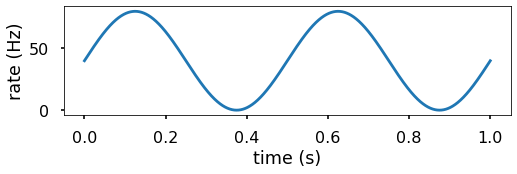

In [66]:
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt
from scipy import special
tmax = 1
max_rate = 80
f_osc =  2
bin_size = 1/30000
time = np.arange(0, tmax, bin_size)

rate = max_rate * (np.sin(2*np.pi*f_osc*time)+1)/2

plt.figure(figsize=(8, 2))
plt.plot(time, rate)
plt.ylabel('rate (Hz)')
plt.xlabel('time (s)');

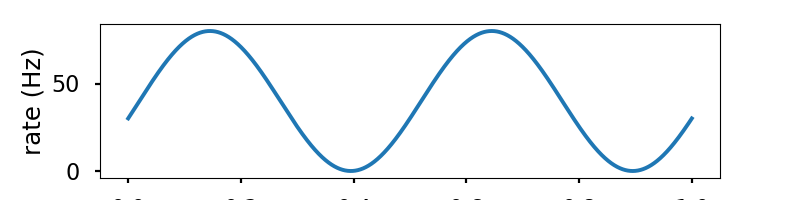

In [20]:
shift = 20/1000   #in ms
rate1 = max_rate * (np.sin(2*np.pi*f_osc*(time - shift))+1)/2
plt.figure(figsize=(8, 2))
plt.plot(time, rate1)
plt.ylabel('rate (Hz)')
plt.xlabel('time (s)');

In [184]:
list(rate1).index(rate1.max())*bin_size,list(rate).index(rate.max())*bin_size
#checking the max point of both the signals

(4350, 3750)

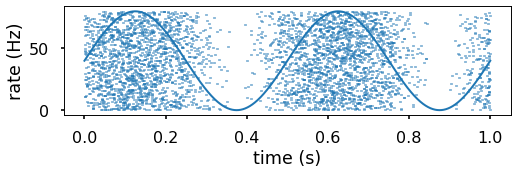

In [185]:
def inhomogeneous_poisson(rate, bin_size):
    n_bins = len(rate)
    spikes = np.random.rand(n_bins) < rate * bin_size
    spike_times = np.nonzero(spikes)[0] * bin_size
    return spike_times

def inhomogeneous_poisson_generator(n_trials, rate, bin_size):
    for i in range(n_trials):
        yield inhomogeneous_poisson(rate, bin_size)

def raster_plot_multi(spike_times):
    for i, spt in enumerate(spike_times):
        plt.vlines(spt, i, i+1)
    plt.yticks([])
    
# Trial generator based on poisson sampling
n_trials = 200

plt.figure(figsize=(8,2))
plt.plot(time, rate, lw=2)
plt.ylabel('rate (Hz)')
plt.xlabel('time (s)')
spike_times = list(inhomogeneous_poisson_generator(n_trials, rate, bin_size))
plt.twinx()
raster_plot_multi(spike_times)

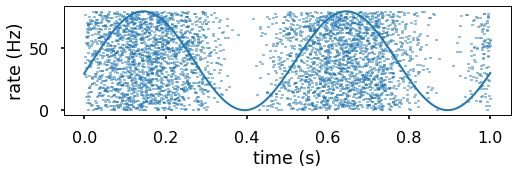

In [10]:
plt.figure(figsize=(8,2))
plt.plot(time, rate1, lw=2)
plt.ylabel('rate (Hz)')
plt.xlabel('time (s)')
spike_times1 = list(inhomogeneous_poisson_generator(n_trials, rate1, bin_size))
plt.twinx()
raster_plot_multi(spike_times1)

In [11]:
spike_vec1 = np.zeros((n_trials, len(rate)))

spike_vec2 = np.zeros((n_trials, len(rate1)))

for j in range(0,n_trials):

    spike_vec1[j, (spike_times[j]/bin_size).astype(int) ] = 1 
    spike_vec2[j, (spike_times1[j]/bin_size).astype(int) ] = 1


In [57]:
spikes = []
spikes_shift = []
for i, spt in enumerate(spike_times):
    hist, edges = np.histogram(np.hstack(spt),bins = len(rate) ) #binwidth=0.033ms
    spikes.append(hist)
    
for i, spt in enumerate(spike_times1):
    hist1, edges = np.histogram(np.hstack(spt),bins = len(rate))
    spikes_shift.append(hist1)

In [12]:
np.array(spike_vec1).shape

(200, 30000)

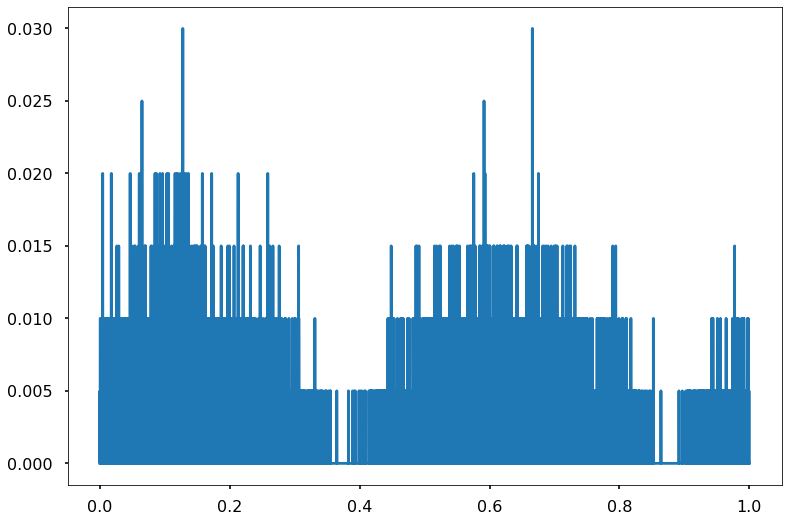

In [13]:
plt.plot(time,np.mean(spike_vec1,axis=0))

# Manual CCG Implementation

In [294]:
CCG_F1= []
for j in range(len(spikes)):
    CCG1 = []
    for n in range(spikes[0].shape[0] - 1):
        CCG1.append(spikes[j][(spikes[0].shape[0] -1 - n):].dot(spikes_shift[j][:n+1]))
        
    CCG1.append(spikes[j].dot(spikes_shift[j]))
    
    for n in range(spikes[0].shape[0] - 2):
        CCG1.append(spikes[j][:(spikes[0].shape[0] -1 -n)].dot(spikes_shift[j][n+1:]))
    CCG_F1.append(CCG1)
CCG1 = np.sum(CCG_F1,axis=0)
CCG1.shape

(59998,)

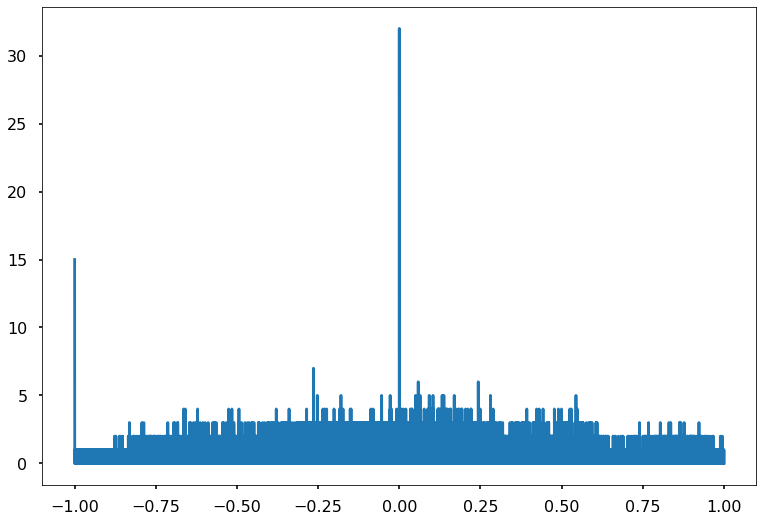

In [295]:
tr = np.arange(-(spikes[0].shape[0] -1),(spikes[0].shape[0] -1))
theta = spikes[0].shape[0] -np.abs(tr)
plt.plot((tr*bin_size),CCG1)   #x-axis 1tick = 0.033ms
#(np.arange(998)- spikes[0].shape[0])/100,
#plt.plot(CCG/(theta*100*np.sqrt(np.mean(spikes)*np.mean(spikes_shift))))

# CCG From Paper(Siegel)

In [67]:
from scipy import stats
import scipy

def jitter(data, l):
    """
    Jittering multidemntational logical data where 
    0 means no spikes in that time bin and 1 indicates a spike in that time bin.
    """
    if len(np.shape(data))>3:
        flag = 1
        sd = np.shape(data)
        data = np.reshape(data,(np.shape(data)[0],np.shape(data)[1],len(data.flatten())/(np.shape(data)[0]*np.shape(data)[1])), order='F')
    else:
        flag = 0

    psth = np.mean(data,axis=1)
    length = np.shape(data)[0]

    if np.mod(np.shape(data)[0],l):
        data[length:(length+np.mod(-np.shape(data)[0],l)),:,:] = 0
        psth[length:(length+np.mod(-np.shape(data)[0],l)),:]   = 0

    if np.shape(psth)[1]>1:
        dataj = np.squeeze(np.sum(np.reshape(data,[l,np.shape(data)[0]//l,np.shape(data)[1],np.shape(data)[2]], order='F'), axis=0))
        psthj = np.squeeze(np.sum(np.reshape(psth,[l,np.shape(psth)[0]//l,np.shape(psth)[1]], order='F'), axis=0))
    else:
        dataj = np.squeeze(np.sum(np.reshape(data,l,np.shape(data)[0]//l,np.shape(data)[1], order='F')))
        psthj = np.sum(np.reshape(psth,l,np.shape(psth)[0]//l, order='F'))


    if np.shape(data)[0] == l:
        dataj = np.reshape(dataj,[1,np.shape(dataj)[0],np.shape(dataj)[1]], order='F');
        psthj = np.reshape(psthj,[1,np.shape(psthj[0])], order='F');

    psthj = np.reshape(psthj,[np.shape(psthj)[0],1,np.shape(psthj)[1]], order='F')
    psthj[psthj==0] = 10e-10

    corr = dataj/np.tile(psthj,[1, np.shape(dataj)[1], 1]);
    corr = np.reshape(corr,[1,np.shape(corr)[0],np.shape(corr)[1],np.shape(corr)[2]], order='F')
    corr = np.tile(corr,[l, 1, 1, 1])
    corr = np.reshape(corr,[np.shape(corr)[0]*np.shape(corr)[1],np.shape(corr)[2],np.shape(corr)[3]], order='F');

    psth = np.reshape(psth,[np.shape(psth)[0],1,np.shape(psth)[1]], order='F');
    output = np.tile(psth,[1, np.shape(corr)[1], 1])*corr

    output = output[:length,:,:]
    return output


def xcorrfft(a,b,NFFT):
    CCG = np.fft.fftshift(np.fft.ifft(np.multiply(np.fft.fft(a,NFFT), np.conj(np.fft.fft(b,NFFT)))))
    return CCG

def nextpow2(n):
    """get the next power of 2 that's greater than n"""
    m_f = np.log2(n)
    m_i = np.ceil(m_f)
    return 2**m_i

def get_ccgjitter(spikes, FR, jitterwindow):
    # spikes: neuron*ori*trial*time
    assert np.shape(spikes)[0]==len(FR)

    n_unit=np.shape(spikes)[0]
    n_t = np.shape(spikes)[3]
    # triangle function
    t = np.arange(-(n_t-1),(n_t-1))
    theta = n_t-np.abs(t)
    NFFT = int(nextpow2(2*n_t))
    target = np.array([int(i) for i in NFFT/2+np.arange((-n_t+2),n_t)])

    ccgjitter = []
    ccgraw = []
    jittered = []
    pair=0
    
    for i in np.arange(n_unit-1): # V1 cell
        for m in np.arange(i+1,n_unit):  # V2 cell
            if FR[i]>2 and FR[m]>2:
                temp1 = np.squeeze(spikes[i,:,:,:])
                temp2 = np.squeeze(spikes[m,:,:,:])
                FR1 = np.squeeze(np.mean(np.sum(temp1,axis=2), axis=1))
                FR2 = np.squeeze(np.mean(np.sum(temp2,axis=2), axis=1))
                tempccg = xcorrfft(temp1,temp2,NFFT)
                tempccg = np.squeeze(np.nanmean(tempccg[:,:,target],axis=1))

#                 temp1 = np.rollaxis(np.rollaxis(temp1,2,0), 2,1)
#                 temp2 = np.rollaxis(np.rollaxis(temp2,2,0), 2,1)
#                 ttemp1 = jitter(temp1,jitterwindow);  
#                 ttemp2 = jitter(temp2,jitterwindow);
#                 tempjitter = xcorrfft(np.rollaxis(np.rollaxis(ttemp1,2,0), 2,1),np.rollaxis(np.rollaxis(ttemp2,2,0), 2,1),NFFT);  
#                 tempjitter = np.squeeze(np.nanmean(tempjitter[:,:,target],axis=1))
                
                ccgraw.append(tempccg.T/np.multiply(np.tile(np.sqrt(FR[i]*FR[m]), (len(target), 1)), 
                    np.tile(theta.T.reshape(len(theta),1),(1,len(FR1)))))
#                 jittered.append(tempjitter.T/np.multiply(np.tile(np.sqrt(FR[i]*FR[m]), (len(target), 1)), 
#                     np.tile(theta.T.reshape(len(theta),1),(1,len(FR1)))))
                
#                 ccgjitter.append((tempccg - tempjitter).T/np.multiply(np.tile(np.sqrt(FR[i]*FR[m]), (len(target), 1)), 
#                     np.tile(theta.T.reshape(len(theta),1),(1,len(FR1)))))

#     ccgjitter = np.array(ccgjitter)
    ccgraw = np.array(ccgraw)
#     jittered = np.array(jittered)
    return ccgraw,t


In [68]:
#np.array(spikes).shape  #Neurons * Orientation * trials * timestamps(5s)

In [69]:
# new_spikes = np.expand_dims(spike_vec1, axis=0)
# new_spikes = np.expand_dims(new_spikes, axis=0)
# new_spikes = np.hstack((new_spikes, new_spikes))
# new_s_spikes = np.expand_dims(spike_vec2, axis=0)
# new_s_spikes = np.expand_dims(new_s_spikes, axis=0)
# new_s_spikes = np.hstack((new_s_spikes, new_s_spikes))
# spik = np.vstack((new_spikes, new_s_spikes))

# FR = spik.sum(-1).mean(1).mean(1)

In [23]:
# spik.shape #Our (Neurons * (2 Orientation with zero degree)(Dummy axis) * trials * timestamp)

In [24]:
def return_smooth_gauss(spike_data,tr,sigma):
    smooth_gauss = []

    for i in np.arange(len(tr)):
        gauss = np.exp((- ( np.arange(len(tr)) - i) ** 2) / ( 2 * (sigma**2) ) )
        gauss /=  sum(gauss)
        smooth_gauss.append(sum(gauss*spike_data))
    
    return tr,smooth_gauss

from math import factorial
def savitzky_golay(y, window_size, order, deriv=0, rate=1):
    try:
        window_size = np.abs(np.int(window_size))
        order = np.abs(np.int(order))
    except ValueError:
        raise ValueError("window_size and order have to be of type int") 
    if window_size % 2 != 1 or window_size < 1:
        raise TypeError("window_size size must be a positive odd number")
    if window_size < order + 2:
        raise TypeError("window_size is too small for the polynomials order")
    order_range = range(order+1)
    half_window = (window_size -1) // 2
     # precompute coefficients
    b = np.mat([[k**i for i in order_range] for k in range(-half_window, half_window+1)]) 
    m = np.linalg.pinv(b).A[deriv] * rate**deriv * factorial(deriv)
    # values taken from the signal itself
    firstvals = y[0] - np.abs( y[1:half_window+1][::-1] - y[0] )
    lastvals = y[-1] + np.abs(y[-half_window-1:-1][::-1] - y[-1])
    y = np.concatenate((firstvals, y, lastvals))
    return np.convolve( m[::-1], y, mode='valid')

# edges,smooth_raw = return_smooth_gauss(raw[0].T[0],tr,0.01)

In [25]:
# smoothing_window = (1/bin_size)/1000   #ms
# print(smoothing_window)
# yhat = savitzky_golay(raw[0].T[0], smoothing_window+1, 7)  #(Data,window,poly order)
# plt.plot(tr*bin_size,yhat)
# plt.plot(tr*bin_size,raw[0].T[0],alpha=0.3)
# plt.xlim(-0.05,0.05)
# plt.ylim(0,0.15e-6)

In [26]:
# plt.plot(tr*bin_size,ccgjitter[0].T[0])
# plt.plot(tr*bin_size,raw[0].T[0],alpha=0.5)
# # plt.xlim(-0.05,0.05)
# plt.ylim(-1.5e-7,1.5e-7)

In [27]:
# plt.plot(tr*bin_size,jit[0].T[0])

# For ALM and Thalamus


In [150]:
units_Data = unit_result.query(" Region == 'left Thalamus' and ses_no == 2")
# thal_spike = units_Data.reset_index().loc[Thalidx]

thal_spike= units_Data[:2]
# thal_spike = units_Data.loc[[160,
# 161,
# 162,
# 163,
# 164,
# 165,
# 166,
# 167,
# 168,
# 169,
# 170,
# 171,
# 172]]
units_Data = unit_result.query(" Region == 'left ALM'  and ses_no == 2")
ALM_spike = units_Data[:2] #.reset_index().loc[ALMidx]

In [151]:
len(thal_spike),len(ALM_spike)

(2, 2)

# Aligned with Delay

In [152]:
after = 4.3     #(Change bins to vector, Done)
before = -0.7
bin_size = 1/2000
def Spike_time(temp_unit):
 
    spike_data_l = []
    n_trials = len(trials_Data_L)
    spike_vec1 = np.zeros((len(temp_unit),n_trials, int((1/bin_size) * (after-before)) ))
   
    
    for unit in temp_unit.reset_index().iloc[:, 0]:
        
        unit_spike_times = temp_unit["spike_times"][unit]
        trial_spikes_l = []
        i = 0
        for time in trials_Data_L['sample_start'].round(3):
            # Compute spike times relative to stimulus onset
            aligned_spikes = unit_spike_times - time
            # Keep only spike times in a given time window around the stimulus onset
            aligned_spikes = aligned_spikes[aligned_spikes < after ]
            aligned_spikes = aligned_spikes[before < aligned_spikes]
            trial_spikes_l.append(aligned_spikes)
        spike_data_l.append(trial_spikes_l)
    for i in range(spike_vec1.shape[0]):
        for j in range(0,n_trials-1):
            spike_vec1[i, j, (spike_data_l[i][j]/bin_size).astype(int) ] = 1 
    return spike_vec1
    
spike_alm = Spike_time(ALM_spike)
spike_thal = Spike_time(thal_spike)

# Aligned with Go que

In [154]:
after = 3.0     #(Change bins to vector, Done)
before = -3.0
bin_size = 1/2000
def Spike_time(temp_unit):
 
    spike_data_l = []
    Time_vec = []
    n_trials = len(trials_Data_L)
    spike_vec1 = np.zeros((len(temp_unit),n_trials, int((1/bin_size) * (after-before)) ))
   
    
    for unit in temp_unit.reset_index().iloc[:, 0]:
        
        unit_spike_times = temp_unit["spike_times"][unit]
        trial_spikes_l = []
        i = 0
        for time in trials_Data_L['go_start'].round(3):
            # Compute spike times relative to stimulus onset
            aligned_spikes = unit_spike_times - time
            # Keep only spike times in a given time window around the stimulus onset
            aligned_spikes = aligned_spikes[aligned_spikes < after ]
            aligned_spikes = aligned_spikes[before < aligned_spikes]
            trial_spikes_l.append(aligned_spikes)
        spike_data_l.append(trial_spikes_l)
    for i in range(spike_vec1.shape[0]):
        for j in range(0,n_trials-1):
            spike_vec1[i, j, ((spike_data_l[i][j]-before)/bin_size).astype(int) ] = 1 
            Time_vec.append(np.multiply(np.where(spike_vec1[i][j] == 1),bin_size)+before)
    return spike_vec1,Time_vec
    
spike_alm,time_alm = Spike_time(ALM_spike)
spike_thal,time_thal = Spike_time(thal_spike)

In [155]:
time_alm[0]

array([[-2.348 , -2.066 , -1.4405, -1.2785, -0.5495, -0.4465, -0.2525,
         0.0605,  0.3425,  0.7375,  1.3885]])

In [157]:
spike_alm.shape

(2, 268, 12000)

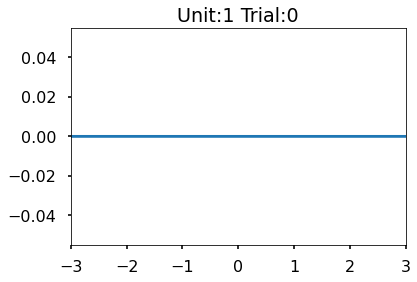

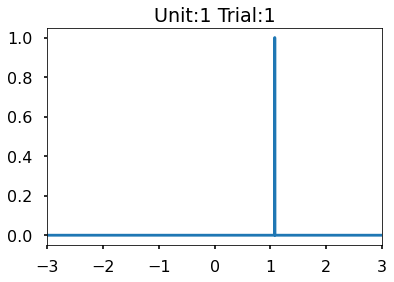

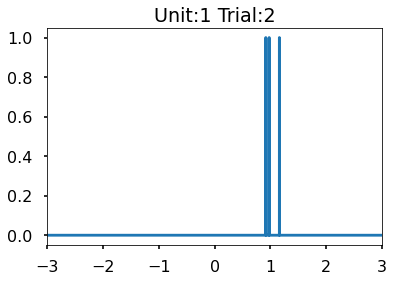

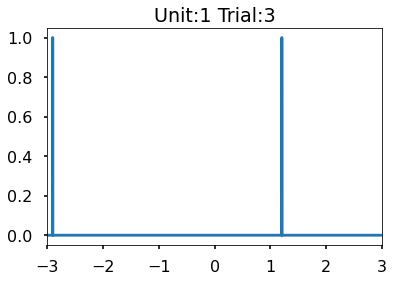

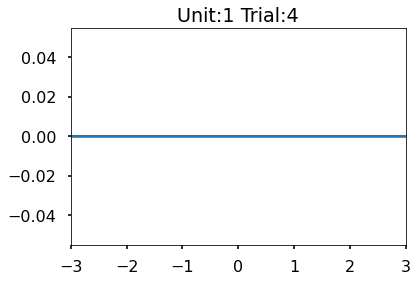

In [177]:
for i in range(5):
    plt.figure()
    plt.plot(np.arange(0,6,bin_size)-3,spike_alm[1][i])
    plt.title("Unit:1 Trial:%s"%i)
    plt.xlim(-3,3)
    plt.savefig('Unit_1_Trial_%s.png' % (i))
    plt.show()

In [76]:
spike_alm1 = spike_alm.T[ int(1.35/bin_size): int(2.55/bin_size)+1].T
spike_thal1 = spike_thal.T[ int(1.35/bin_size): int(2.55/bin_size)+1].T

In [77]:
spike_thal1.shape  #previously 150alm,145thal

(186, 172, 2400)

In [78]:
%matplotlib inline

# new_spikes = np.expand_dims(spike_alm[0], axis=0)
# new_spikes = np.expand_dims(new_spikes, axis=0)
# new_spikes = np.hstack((new_spikes, new_spikes))

# FR = new_spikes.sum(-1).mean(1).mean(1)

In [79]:
spike_alm1.shape

(81, 172, 2400)

In [29]:
# ind=[]
# for i in range(101):
#     a = np.where(spike_alm[1][i]==1)
#     ind.append(a)

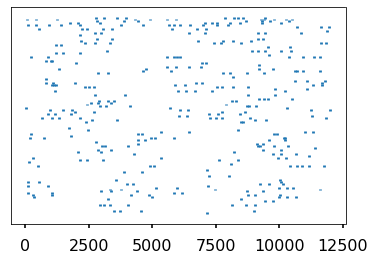

In [220]:
# raster_plot_multi(ind)

In [159]:
def get_ccg_plot(spike_alm,spike_thal):
    new_spikes = np.expand_dims(spike_alm, axis=0)
    new_spikes = np.expand_dims(new_spikes, axis=0)
    new_spikes = np.hstack((new_spikes, new_spikes))

    new_s_spikes = np.expand_dims(spike_thal, axis=0)
    new_s_spikes = np.expand_dims(new_s_spikes, axis=0)
    new_s_spikes = np.hstack((new_s_spikes, new_s_spikes))
    
    spik = np.vstack((new_spikes, new_s_spikes))

    FR = spik.sum(-1).mean(1).mean(1)
    jitterwindow = 25/bin_size/1000  #in ms
    
    raw,tr = get_ccgjitter(spik, FR, jitterwindow= int(jitterwindow))
    return raw,tr

In [160]:
%matplotlib inline

# raw = []
# for i in range(len(spike_alm)):
#     for j in range(len(spike_thal)):
#         r,tr = get_ccg_plot(spike_alm[i],spike_thal[j])
# #         ccg.append(c)
#         raw.append(r)

raw = []
for i in range(1):
    for j in range(1):
        r,tr = get_ccg_plot(spike_alm[0],spike_alm[1])
#         ccg.append(c)
        raw.append(r)

In [32]:
# raw,tr = get_ccg_plot(spike_alm[2],spike_thal[29])

In [161]:
np.array(raw).shape

(1, 1, 23998, 2)

In [9]:
import pickle
# with open('ALM_THAL_440959_with0.5ms.pkl', 'wb') as f:
#     pickle.dump(raw, f)
# with open('ALM_THAL_100_RAW_3.pkl', 'rb') as f:
#     raw3 = pickle.load(f)
# with open('ALM_THAL_100_RAW_2.pkl', 'rb') as f:
#     raw2 = pickle.load(f)
with open('ALM_THAL_440959_with0.5ms.pkl', 'rb') as f:
    raw = pickle.load(f)

In [84]:
# bin_size=1/10000
n_t = spike_alm.shape[2]
tr = np.arange(-(n_t-1),(n_t-1))
def get_slice(ccgs, rang1,rang2):
    return (ccgs[0].T[0][int((n_t + (rang1/1000/bin_size))): int((n_t + (rang2/1000/bin_size)))])

def get_peak(raws):
    j = 0
    for i in range(len(raws)):
        if raws[i].shape[0] != 0:
            sd=np.std(get_slice(raws[i],-50,50))
            rel_max = np.max(get_slice(raws[i],-10,10))
            rel_min = np.min(get_slice(raws[i],-10,10))
            relpeak = rel_max-rel_min
            if float(relpeak/sd)>6:
                j = j+1
                plt.figure()
                plt.plot(tr*bin_size,raws[i][0].T[0])
                plt.xlim(-0.05,0.05)
                plt.ylim(0,rel_max*1.2)
#                 plt.savefig('ALM_THAL_0.5ms_%s.png' % (i))
                plt.show()
    print(j)

G:\Anaconda\lib\site-packages\matplotlib\cbook\__init__.py:1333: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


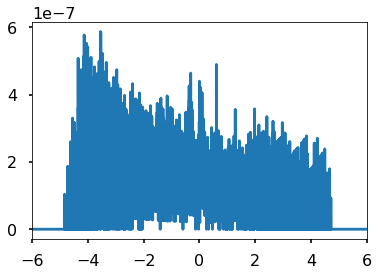

In [166]:
for i in range(len(raw)):
    if raw[i].shape[0] != 0:
        plt.figure()
        plt.plot(tr*bin_size,raw[i][0].T[0])
        plt.xlim(-6,6)
#         plt.ylim(0,np.max(get_slice(raw[i],-5000,5000))*1.2)
        plt.show()

C:\Users\smit3\AppData\Local\Temp/ipykernel_3112/1511488111.py:15: ComplexWarning: Casting complex values to real discards the imaginary part
  if float(relpeak/sd)>6:
G:\Anaconda\lib\site-packages\matplotlib\cbook\__init__.py:1333: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
G:\Anaconda\lib\site-packages\matplotlib\transforms.py:2837: ComplexWarning: Casting complex values to real discards the imaginary part
  vmin, vmax = map(float, [vmin, vmax])


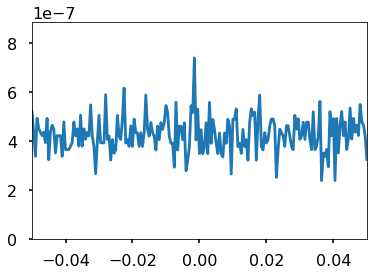

1


C:\Users\smit3\AppData\Local\Temp/ipykernel_3112/1511488111.py:15: ComplexWarning: Casting complex values to real discards the imaginary part
  if float(relpeak/sd)>6:


In [85]:
get_peak(raw)

# Controlled Env

In [70]:
units_Data = unit_result.query(" Region == 'left Thalamus'")
thal_spike = units_Data[:1]

after = 4.3     #(Change bins to vector, Pending**)
before = -0.7
bin_size = 1/30000
def Spike_time(temp_unit,i):
 
    spike_data_l = []
    n_trials = len(trials_Data_L)
    spike_vec1 = np.zeros((len(temp_unit),n_trials, int((1/bin_size) * (after-before)) ))
   
    
    for unit in temp_unit.reset_index()['index']:
        if(i==1):
            unit_spike_times = np.asarray(temp_unit["spike_times"][unit]) + 0.005 
        else:
            unit_spike_times = np.asarray(temp_unit["spike_times"][unit])
        trial_spikes_l = []
        i = 0
        for time in trials_Data_L['sample_start'].round(3):
            # Compute spike times relative to stimulus onset
        
            aligned_spikes = unit_spike_times - time
            # Keep only spike times in a given time window around the stimulus onset
            aligned_spikes = aligned_spikes[aligned_spikes < after ]
            aligned_spikes = aligned_spikes[before < aligned_spikes]
            trial_spikes_l.append(aligned_spikes)
        spike_data_l.append(trial_spikes_l)
    for i in range(spike_vec1.shape[0]):
        for j in range(0,n_trials-1):
            spike_vec1[i, j, (spike_data_l[i][j]/bin_size).astype(int) ] = 1 
    return spike_vec1
    
spike_alm = Spike_time(thal_spike,0)
spike_thal = Spike_time(thal_spike,1)

(79100.0, 79320.0)

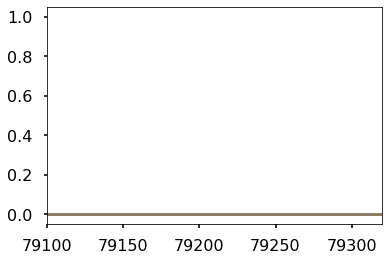

In [71]:
plt.plot(spike_thal[0][0])
plt.plot(spike_alm[0][0],alpha=0.5)
plt.xlim(79100,79320)

In [72]:
new_spikes = np.expand_dims(spike_alm, axis=1)
# new_spikes = np.expand_dims(new_spikes, axis=0)
new_spikes = np.hstack((new_spikes, new_spikes))

new_s_spikes = np.expand_dims(spike_thal, axis=1)
# new_s_spikes = np.expand_dims(new_s_spikes, axis=0)
new_s_spikes = np.hstack((new_s_spikes, new_s_spikes))

spik = np.vstack((new_spikes, new_s_spikes))

FR = spik.sum(-1).mean(1).mean(1)
spik.shape

(2, 2, 101, 150000)

In [73]:
tr = np.arange(-(spike_alm[0][0].shape[0]-1),(spike_alm[0][0].shape[0]-1))
theta = spike_alm[0][0].shape[0] -np.abs(tr)
jitterwindow = 25/bin_size/1000  #in ms
rawcon,jitcon,ccgjittercon = get_ccgjitter(spik, FR, jitterwindow= int(jitterwindow))

In [74]:
ccgjittercon.shape

(1, 299998, 2)

G:\Anaconda\lib\site-packages\matplotlib\cbook\__init__.py:1333: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


Text(0.5, 0, 'Time(s)')

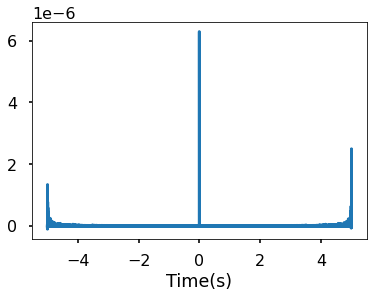

In [75]:
plt.plot(tr*bin_size,ccgjittercon[0].T[0])
# plt.xlim(-0.01,0.01)
plt.xlabel("Time(s)")